해당 코드의 FE 까지는 정은 님께서 작성하여주셨습니다.
그 위에 0902 수업에서 배운 DNN모델을 그대로 적용하였습니다.

제출 점수는 public점수: 17.9125345273, private점수: 17.53488159를 획득했습니다.

청경채 성장 예측 AI 경진대회
https://dacon.io/competitions/official/235961/overview/description

## Import Library 

In [10]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


feature_list = [
    '시간',
    '내부온도관측치', '내부습도관측치',
    'CO2관측치', 'EC관측치',
    '외부온도관측치', '외부습도관측치',
    '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량',
    '냉방상태', '냉방작동남은시간', '난방상태', '난방작동남은시간',
    '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
    '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도',
    '레드 LED상태', '레드 LED작동남은시간', '레드 LED동작강도',
    '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도',
    '카메라상태',
    '냉방온도', '난방온도', '기준온도', '난방부하', '냉방부하',
    '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량'
]


In [2]:
# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [3]:
seed_number = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed_number)

In [56]:
train_input_list = sorted(glob('/content/drive/My Drive/Colab Notebooks/BokChoy/train_input/*.csv'))
train_target_list = sorted(glob('/content/drive/My Drive/Colab Notebooks/BokChoy/train_target/*.csv'))
test_input_list = sorted(glob('/content/drive/My Drive/Colab Notebooks/BokChoy/test_input/*.csv'))
test_target_list = sorted(glob('/content/drive/My Drive/Colab Notebooks/BokChoy/test_target/*.csv'))

In [57]:
pd.read_csv(train_input_list[0]).columns, len(pd.read_csv(train_input_list[0]).columns)

(Index(['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치',
        '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태',
        '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
        '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간',
        '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도',
        '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
        '청색광추정광량'],
       dtype='object'), 38)

In [13]:
# 각 컬럼 다 같은지 확인 
for i,v in enumerate(train_input_list):
    cnt = len(pd.read_csv(v).columns)
    if cnt != 38:
        print(f'38개가 아닌 컬럼 : CASE-{i+1} : {cnt}개\n{v}')
        set()
    if set(pd.read_csv(v).columns)!= set(feature_list):
        print(f'CASE-{i+1}:')
        print(f'서로 다른 컬럼 : {set(pd.read_csv(v).columns) - set(feature_list)}')
        print(f'서로 같은 컬럼 : {set(pd.read_csv(v).columns) & set(feature_list)}')
else:
    print('done')

CASE-10:
서로 다른 컬럼 : {'펌프작동남은시간.1'}
서로 같은 컬럼 : {'내부유동팬상태', '펌프작동남은시간', '백색광추정광량', '레드 LED작동남은시간', '카메라상태', '총추정광량', '내부온도관측치', '블루 LED동작강도', '화이트 LED동작강도', 'EC관측치', '최근분무량', 'CO2관측치', '내부습도관측치', '외부온도관측치', '난방상태', '냉방상태', '난방부하', '난방작동남은시간', '화이트 LED상태', '냉방부하', '블루 LED작동남은시간', '기준온도', '청색광추정광량', '냉방온도', '난방온도', '적색광추정광량', '외부환기팬상태', '냉방작동남은시간', '시간', '레드 LED동작강도', '블루 LED상태', '레드 LED상태', '펌프상태', '화이트 LED작동남은시간', '외부환기팬작동남은시간', '외부습도관측치', '내부유동팬작동남은시간'}
CASE-18:
서로 다른 컬럼 : {'펌프작동남은시간.1'}
서로 같은 컬럼 : {'내부유동팬상태', '펌프작동남은시간', '백색광추정광량', '레드 LED작동남은시간', '카메라상태', '총추정광량', '내부온도관측치', '블루 LED동작강도', '화이트 LED동작강도', 'EC관측치', '최근분무량', 'CO2관측치', '내부습도관측치', '외부온도관측치', '난방상태', '냉방상태', '난방부하', '난방작동남은시간', '화이트 LED상태', '냉방부하', '블루 LED작동남은시간', '기준온도', '청색광추정광량', '냉방온도', '난방온도', '적색광추정광량', '외부환기팬상태', '냉방작동남은시간', '시간', '레드 LED동작강도', '블루 LED상태', '레드 LED상태', '펌프상태', '화이트 LED작동남은시간', '외부환기팬작동남은시간', '외부습도관측치', '내부유동팬작동남은시간'}
CASE-30:
서로 다른 컬럼 : {'외부습도추정관측치', '외부온도추정관측치'}
서로 같은 컬럼 : {'내부유동팬상태', '펌프작동남은시간', '백색광

In [14]:
# 각 컬럼 다 같은지 확인 
for i,v in enumerate(train_target_list):
    cnt = len(pd.read_csv(v).columns)
#     if cnt != 38:
#         print(f'38개가 아닌 컬럼 : CASE-{i+1} : {cnt}개\n{v}')
#         set()
    if set(pd.read_csv(v).columns)!= set(pd.read_csv(train_target_list[0]).columns):
        print(f'CASE-{i+1}:')
        print(f'서로 다른 컬럼 : {set(pd.read_csv(v).columns) - set(feature_list)}')
        print(f'서로 같은 컬럼 : {set(pd.read_csv(v).columns) & set(feature_list)}')
else:
    print('done')

done


CASE_29의 경우 "외부온도관측치"인데 CASE_30의 경우 "외부온도추정관측치"로 같은 컬럼이지만 미묘하게 다르게 지정되어져있다.     
이부분에 대한 처리가 필요해보인다. 
    
이렇게 변수명(column name)이 다른 나머지 변수들은 "펌프작동남은시간.1", "외부온도추정관측치" , "외부습도추정관측치", "펌프최근분무량", "펌프일간누적분무량"   

### 베이스라인 코드들 분석 
- 기존 심플 LSTM 모델 : 1분 

In [ ]:
df_1 = pd.read_csv(train_input_list[0])
df_1.head()

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,...,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-02-17 00:00:00,24.799999,40.500000,361.0,0.059069,20.299999,33.200001,0.0,0.0,0.0,...,4.5,0.0,0.0,363.554,16.548,37.596000,363.554,309.41,16.548,37.596
1,2021-02-17 00:01:00,20.500000,44.099998,355.0,0.910134,19.700001,10.700000,0.0,0.0,0.0,...,0.0,20.0,18.0,19.000,0.000,2.500000,0.000,0.00,0.000,0.000
2,2021-02-17 00:02:00,20.600000,44.299999,360.0,0.910134,19.799999,10.600000,0.0,0.0,0.0,...,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000
3,2021-02-17 00:03:00,20.600000,44.500000,359.0,0.908579,19.799999,10.400000,0.0,0.0,0.0,...,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000
4,2021-02-17 00:04:00,20.600000,44.500000,357.0,0.910134,19.799999,10.300000,0.0,0.0,0.0,...,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000


In [ ]:
pd.read_csv(train_target_list[0]).head()

,시간,rate
0,2021-02-18 00:00:00,0.50000
1,2021-02-19 00:00:00,0.66667
2,2021-02-20 00:00:00,0.60000
3,2021-02-21 00:00:00,-0.12500
4,2021-02-22 00:00:00,1.42857


### 데이터 병합 및 컬럼 수정 

In [15]:
import argparse

In [16]:
parser = argparse.ArgumentParser(description="baseline")
parser.add_argument('--best_n', default=8, type=int)
parser.add_argument('--missing', default="f", type=str) # b, f, i
parser.add_argument('--scaler', default="robust", type=str) # standard or minmax or robust
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

best_n = args.best_n
missing = args.missing
scaler = args.scaler
cv = args.cv
seed = args.seed

In [58]:
from tqdm import tqdm
import datetime

feature_list = [
    '시간',
    '내부온도관측치', '내부습도관측치',
    'CO2관측치', 'EC관측치',
    '외부온도관측치', '외부습도관측치',
    '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량',
    '냉방상태', '냉방작동남은시간', '난방상태', '난방작동남은시간',
    '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
    '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도',
    '레드 LED상태', '레드 LED작동남은시간', '레드 LED동작강도',
    '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도',
    '카메라상태',
    '냉방온도', '난방온도', '기준온도', '난방부하', '냉방부하',
    '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량'
]


def preprocess_data(input_paths, target_paths):
    
    idx = 0
    
    temp_df = pd.DataFrame()
    for input_path, target_path in tqdm(zip(input_paths, target_paths)):
        
        idx+=1
        
        input_df = pd.read_csv(input_path) # input 
        target_df = pd.read_csv(target_path) # target 
        
        input_df.columns = feature_list  # 
        
        input_df["시간"] = pd.to_datetime(input_df["시간"]) + datetime.timedelta(days=1)
        input_df["year"] = input_df["시간"].dt.year
        input_df["month"] = input_df["시간"].dt.month
        input_df["day"] = input_df["시간"].dt.day
        
        target_df["시간"] = pd.to_datetime(target_df["시간"]) 
        target_df["year"] = input_df["시간"].dt.year
        target_df["month"] = target_df["시간"].dt.month
        target_df["day"] = target_df["시간"].dt.day
        
        input_df = input_df.groupby(by=["year", "month", "day"]).median().reset_index()
        target_df = target_df.groupby(by=["year", "month", "day"]).median().reset_index()
        
        if missing == "b":
            input_df = input_df.fillna(method='bfill')
        if missing == "f":
            input_df = input_df.fillna(method='ffill')
        if missing == "i":
            input_df = input_df.interpolate()
        
        input_df["time"] = np.arange(0, len(input_df))
        input_df["case"] = idx
        df = pd.merge(input_df, target_df) # 시간 기준 rate 합쳐줌 
        temp_df = pd.concat([temp_df, df], axis=0)
        
    temp_df = temp_df.reset_index(drop=True)    
    return temp_df

train_df = preprocess_data(train_input_list, train_target_list)
test_df = preprocess_data(test_input_list, test_target_list)

58it [00:17,  3.34it/s]
6it [00:02,  2.36it/s]


```
Dataset Info.

train_input [폴더] - 총 58개 청경채 케이스
각 청경채 케이스 별 환경 데이터 (1분 간격)


train_target [폴더] - 총 58개 청경채 케이스
rate : 각 청경채 케이스 별 잎 면적 증감률 (1일 간격)


test_input [폴더] - 총 6개 청경채 케이스
각 청경채 케이스 별 환경 데이터 (1분 간격)


test_target [폴더] - 총 6개 청경채 케이스
rate : 각 청경채 케이스 별 잎 면적 증감률 (1일 간격)
제출을 위한 양식으로 label에 해당되는 rate의 값은 모두 0으로 가려져있습니다.


submission 은 각 케이스 별로 쪼갠 rate값에 대한 RMSE*100 값을 입력하여 제출
```



In [59]:
train_df.shape , test_df.shape

((1813, 43), (195, 43))

In [ ]:
test_df.head()

,year,month,day,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,...,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,time,case,rate
0,2021,3,27,27.600000,24.200001,486.0,1.825927,28.400000,18.400000,0.0,...,22.165345,0.0,18.999996,0.0000,0.0000,0.0,0.0,0,1,0.0
1,2021,3,28,29.299999,40.200001,474.0,1.874167,30.200001,21.299999,0.0,...,22.150231,0.0,25.618236,0.0000,0.0000,0.0,0.0,1,1,0.0
2,2021,3,29,32.000000,44.700001,432.0,1.854575,35.299999,26.100000,0.0,...,22.175592,0.0,41.499996,0.0000,0.0000,0.0,0.0,2,1,0.0
3,2021,3,30,30.500000,43.000000,445.0,1.894089,34.700001,18.700001,0.0,...,20.500000,0.0,41.499996,0.0000,0.0000,0.0,0.0,3,1,0.0
4,2021,3,31,30.600000,39.099998,440.0,1.909895,31.750000,10.200000,0.0,...,22.179347,0.0,25.500002,102.1053,102.1053,0.0,0.0,4,1,0.0


Target이 Rate

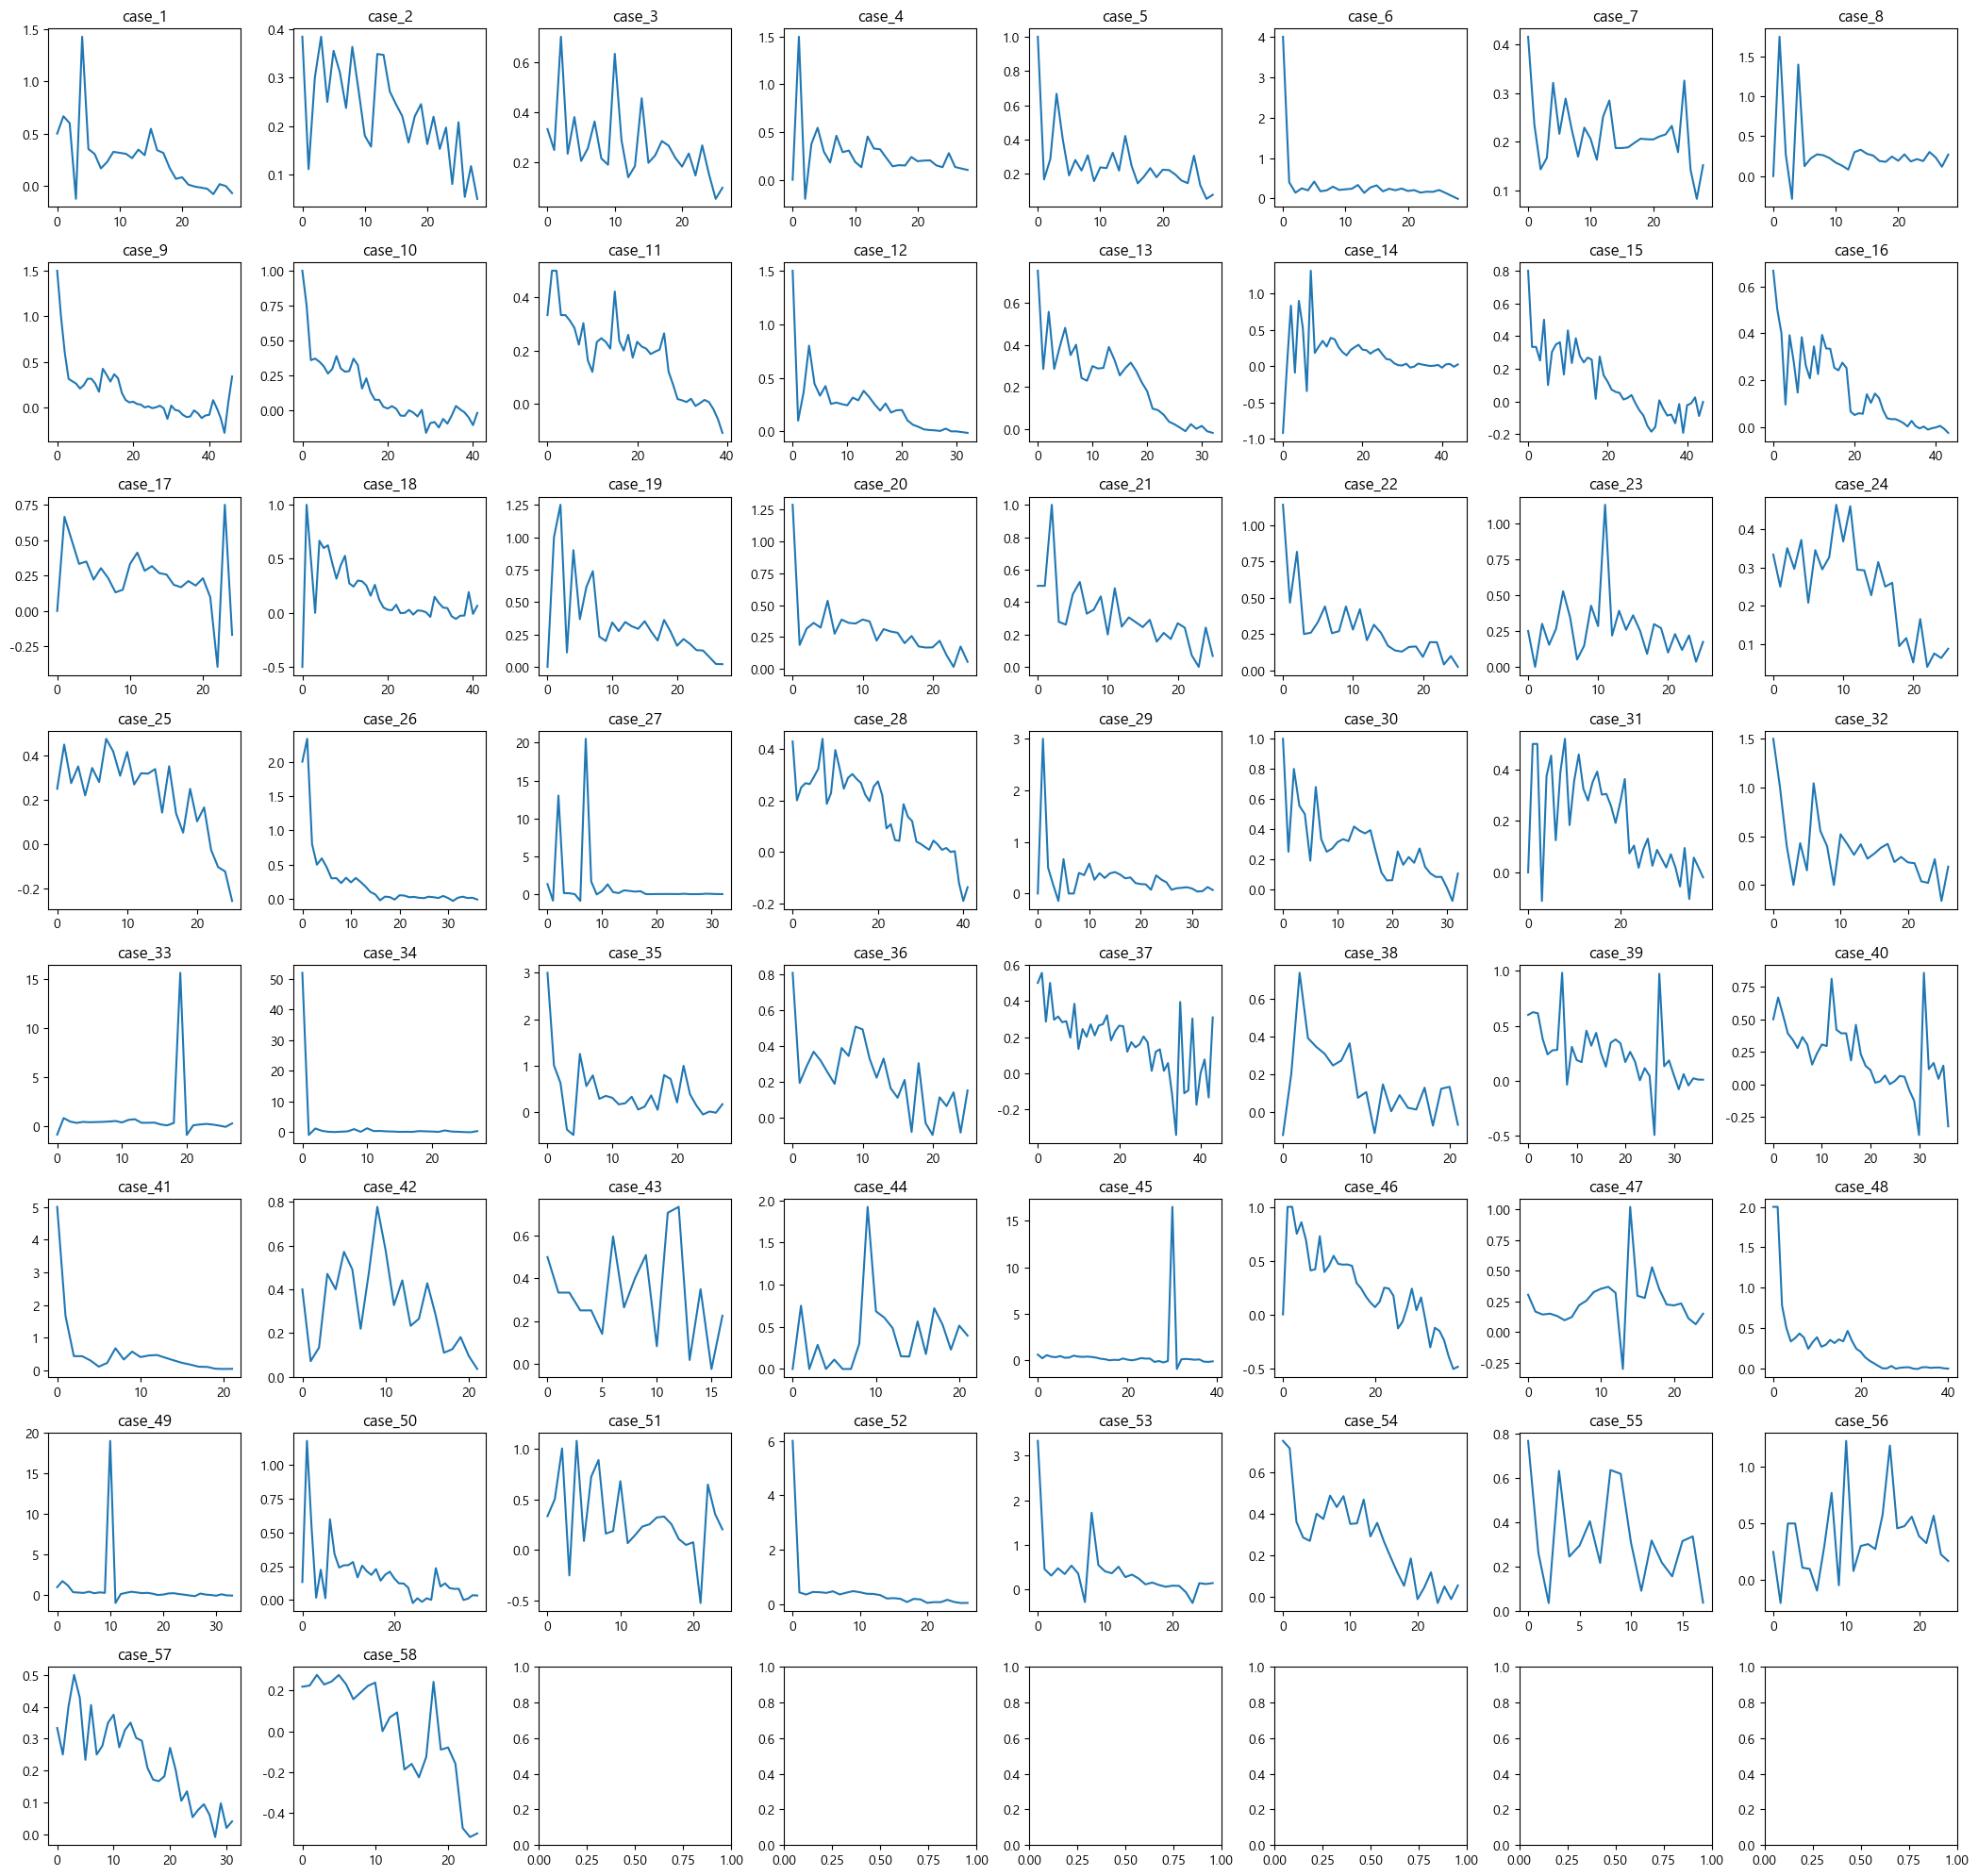

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(21,20))

axs = axs.ravel(order='C')
for i, v in enumerate(train_df["case"].unique()):
    axs[i].plot(train_df["rate"][train_df["case"]==v].reset_index(drop=True))
    axs[i].set_title(f"case_{v}")
plt.tight_layout()
plt.show()

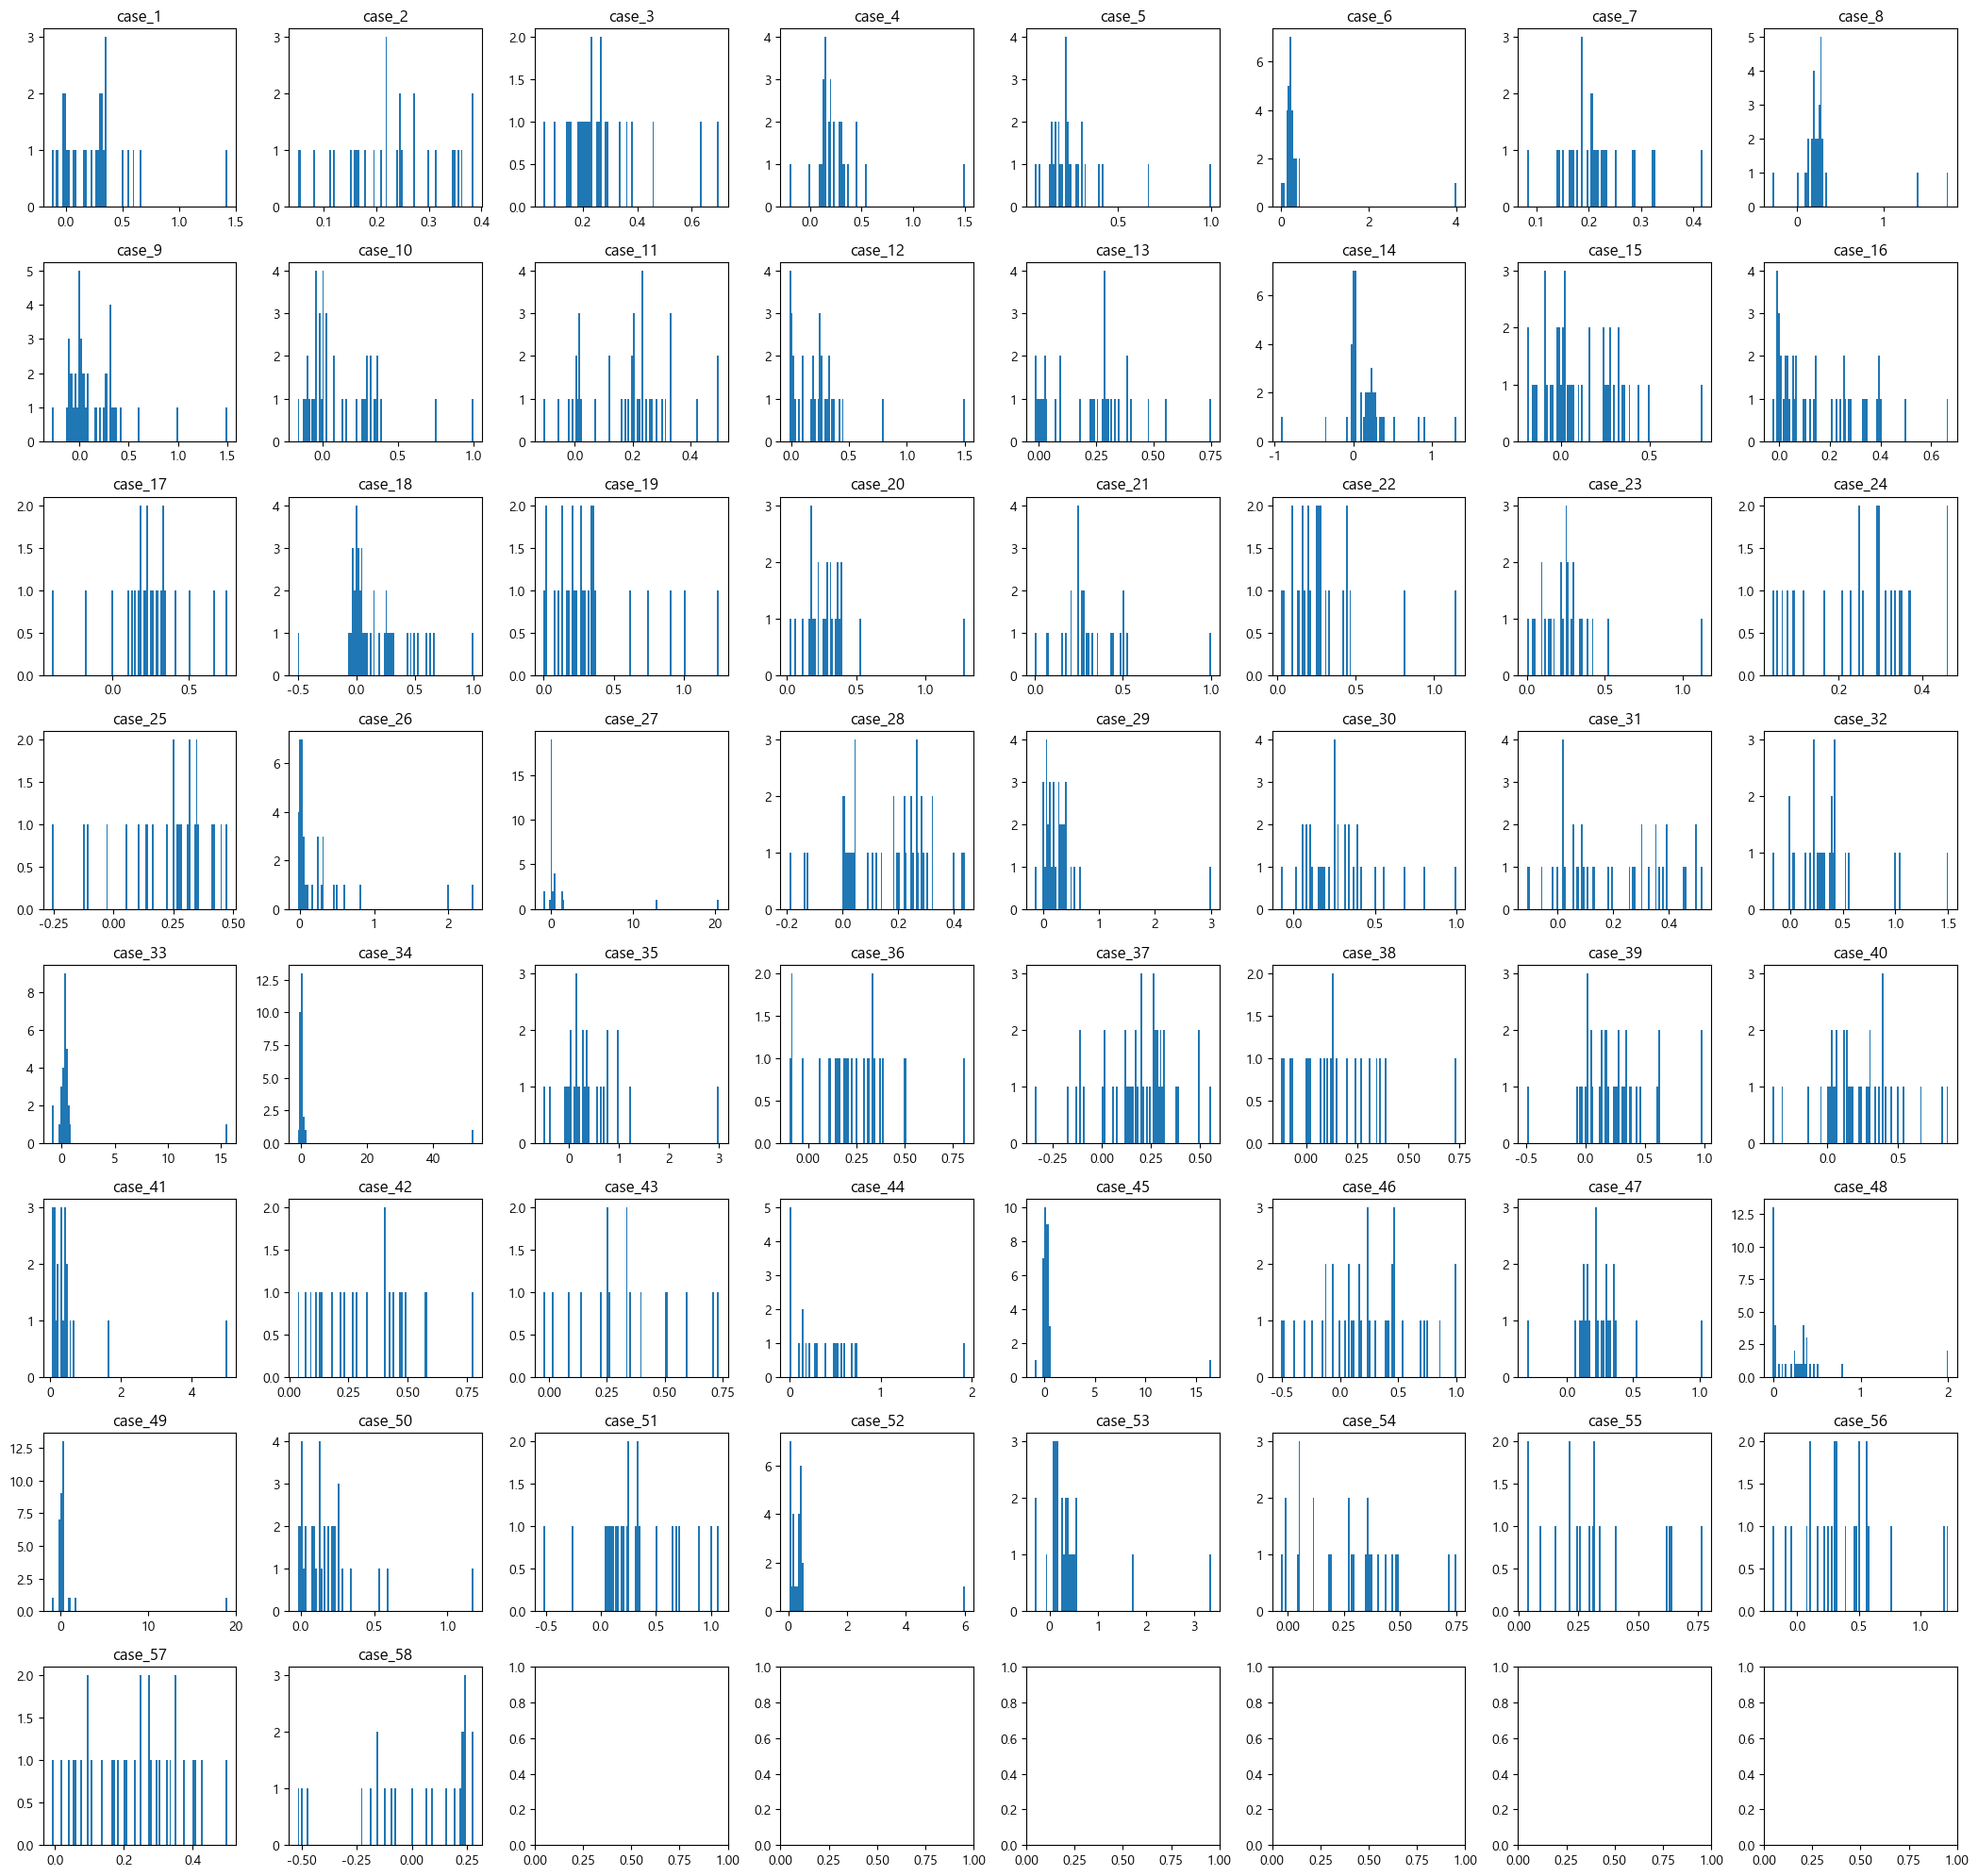

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(21,20))

axs = axs.ravel(order='C')
for i, v in enumerate(train_df["case"].unique()):
    axs[i].hist(train_df["rate"][train_df["case"]==v].reset_index(drop=True),bins=100)
    axs[i].set_title(f"case_{v}")
    
plt.tight_layout()
plt.show()

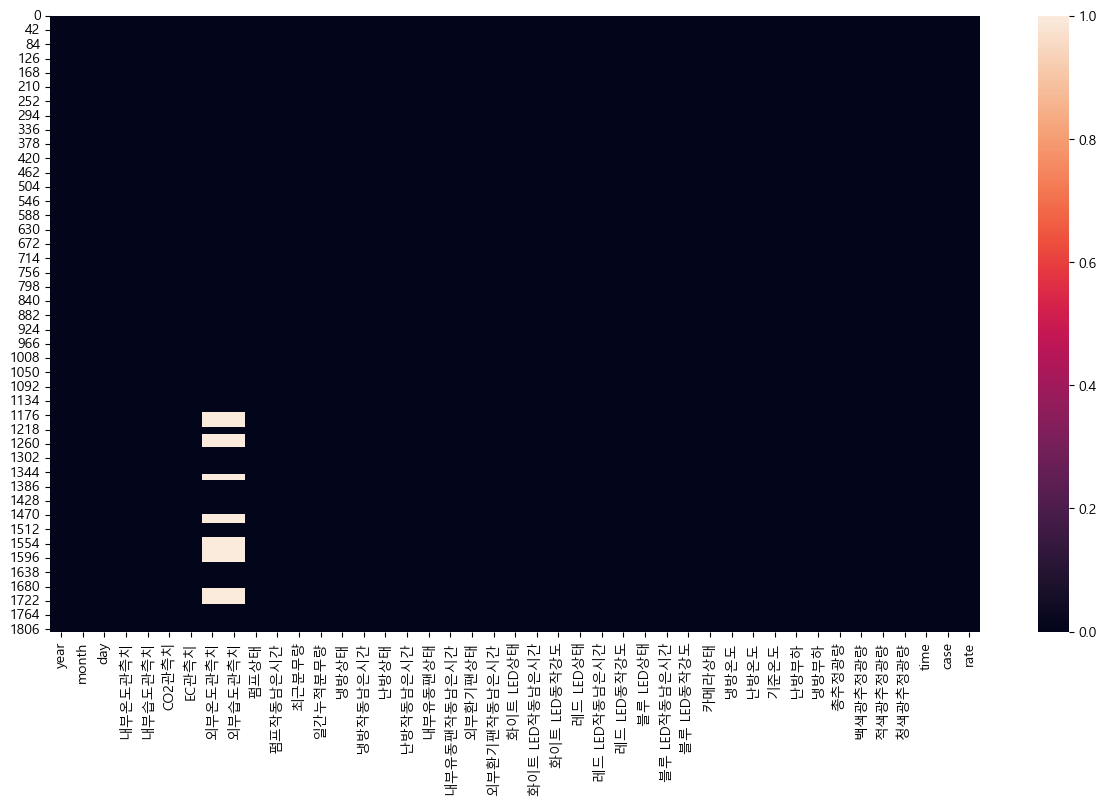

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(train_df.isnull())
plt.show()

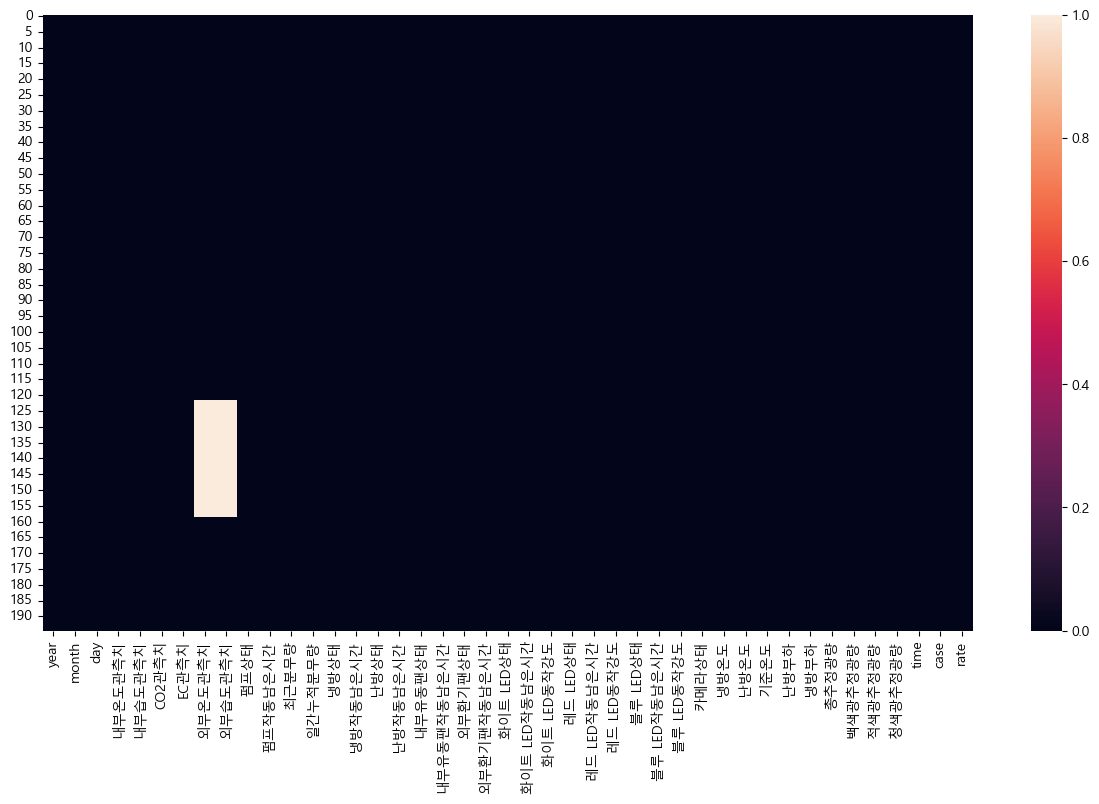

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(test_df.isnull())
plt.show()

- 외부 온도 관측치, 외부 습도 관측치 결측치 발생

In [60]:
train_df.columns

Index(['year', 'month', 'day', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치',
       '외부온도관측치', '외부습도관측치', '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태',
       '냉방작동남은시간', '난방상태', '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태',
       '외부환기팬작동남은시간', '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태',
       '레드 LED작동남은시간', '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도',
       '카메라상태', '냉방온도', '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량',
       '적색광추정광량', '청색광추정광량', 'time', 'case', 'rate'],
      dtype='object')

In [61]:
train_df

,year,month,day,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,...,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,time,case,rate
0,2021,2,18,22.299999,26.700001,397.0,0.917129,19.100000,10.000000,0.0,...,20.705163,0.0,1.000004,0.0000,0.00000,0.0000,0.00000,0,1,0.50000
1,2021,2,19,21.900000,33.299999,357.0,0.910134,17.700001,11.100000,0.0,...,20.665922,0.0,0.000000,0.0000,0.00000,0.0000,0.00000,1,1,0.66667
2,2021,2,20,22.150001,31.349999,354.0,0.910134,18.100000,13.400000,0.0,...,20.666866,0.0,0.000000,0.0000,0.00000,0.0000,0.00000,2,1,0.60000
3,2021,2,21,23.600000,23.100000,349.0,0.910134,20.200001,20.299999,0.0,...,20.665137,0.0,1.999998,0.0000,0.00000,0.0000,0.00000,3,1,-0.12500
4,2021,2,22,24.650001,44.799999,373.0,0.910134,22.000000,22.500000,0.0,...,20.675179,0.0,3.999996,0.0000,0.00000,0.0000,0.00000,4,1,1.42857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2022,6,11,23.799999,65.800003,459.0,0.011633,25.200001,41.500000,0.0,...,15.428755,0.0,40.500002,111.7692,95.91710,6.6192,6.26600,20,58,-0.07888
1809,2022,6,12,23.500000,64.199997,505.0,0.010857,25.200001,41.500000,0.0,...,15.425492,0.0,40.500002,111.7692,95.91710,6.6192,4.69950,21,58,-0.15838
1810,2022,6,13,23.250000,63.200001,415.5,0.010082,25.200001,41.500000,0.0,...,15.433483,0.0,38.999996,111.3481,95.91710,6.6192,5.48275,22,58,-0.47374
1811,2022,6,14,23.299999,63.200001,479.0,0.010082,25.200001,41.500000,0.0,...,15.426235,0.0,36.999998,111.7692,99.01120,6.6192,6.26600,23,58,-0.51767


- 난방상태, 냉방상태 , 카메라 상태 펌프상태 펌프작동남은시간     

In [ ]:
train_df.groupby('year')['month'].value_counts()

year  month
2021  6        289
      4        240
      5        215
      9         55
      3         51
      7         41
      10        20
      2         11
2022  5        240
      4        235
      2        211
      3        178
      6         15
      1         12
Name: month, dtype: int64

In [ ]:
test_df.groupby('year')['month'].value_counts()

year  month
2021  5        30
      4        29
      6        26
      3         5
2022  4        32
      2        28
      3        26
      5        18
      1         1
Name: month, dtype: int64

In [62]:
train_df = train_df.fillna(method="bfill") #  bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다. 
# 보간법의 원리 
test_df = test_df.fillna(method="bfill")

print(train_df.shape, test_df.shape)
print(train_df.isnull().sum().sum(),test_df.isnull().sum().sum())

(1813, 43) (195, 43)
0 0


In [63]:
ignore_features = ['펌프상태','난방상태','난방작동남은시간','내부유동팬상태','외부온도관측치','외부습도관측치'] 


feature = list(set(['year', 'month', 'day', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치',
       '외부온도관측치', '외부습도관측치', '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태',
       '냉방작동남은시간', '난방상태', '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태',
       '외부환기팬작동남은시간', '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태',
       '레드 LED작동남은시간', '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도',
       '카메라상태', '냉방온도', '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량',
       '적색광추정광량', '청색광추정광량', 'time', 'case', 'rate']) - set(ignore_features))
feature


['day',
 '펌프작동남은시간',
 '백색광추정광량',
 '레드 LED작동남은시간',
 '카메라상태',
 '총추정광량',
 '내부온도관측치',
 'time',
 'EC관측치',
 '최근분무량',
 '화이트 LED동작강도',
 '블루 LED동작강도',
 'CO2관측치',
 '내부습도관측치',
 '냉방상태',
 'month',
 '난방부하',
 '화이트 LED상태',
 '냉방부하',
 'rate',
 '블루 LED작동남은시간',
 '기준온도',
 '청색광추정광량',
 'case',
 '냉방온도',
 '난방온도',
 '적색광추정광량',
 '외부환기팬상태',
 '냉방작동남은시간',
 '레드 LED동작강도',
 '블루 LED상태',
 '레드 LED상태',
 '화이트 LED작동남은시간',
 '외부환기팬작동남은시간',
 '일간누적분무량',
 '내부유동팬작동남은시간',
 'year']

In [64]:
for col in train_df.columns.tolist():
    if train_df[col].nunique() < 10 :
        print(f'{col} Feature 의 unique 값')
        print(f'{train_df[col].unique()}\n')

year Feature 의 unique 값
[2021 2022]

month Feature 의 unique 값
[ 2  3  4  5  6  7  9 10  1]

펌프상태 Feature 의 unique 값
[0.]

펌프작동남은시간 Feature 의 unique 값
[  0.         201.           1.5          2.           2.1193609
   6.90601504]

난방상태 Feature 의 unique 값
[0.]

난방작동남은시간 Feature 의 unique 값
[0.]

내부유동팬상태 Feature 의 unique 값
[  0. 201.]

내부유동팬작동남은시간 Feature 의 unique 값
[    0.  56796.5 10713.  13206. ]

외부환기팬상태 Feature 의 unique 값
[  0.         201.         100.5        130.07154384]



In [65]:
for col in test_df.columns.tolist():
    if test_df[col].nunique() < 10 :
        print(f'{col} Feature 의 unique 값')
        print(f'{test_df[col].unique()}\n')

year Feature 의 unique 값
[2021 2022]

month Feature 의 unique 값
[3 4 5 6 1 2]

펌프상태 Feature 의 unique 값
[0.]

펌프작동남은시간 Feature 의 unique 값
[0.]

냉방상태 Feature 의 unique 값
[201.           0.         168.19114078]

난방상태 Feature 의 unique 값
[0.]

난방작동남은시간 Feature 의 unique 값
[0.]

내부유동팬상태 Feature 의 unique 값
[0.]

내부유동팬작동남은시간 Feature 의 unique 값
[0.]

외부환기팬상태 Feature 의 unique 값
[  0. 201.]

화이트 LED상태 Feature 의 unique 값
[201.   0.]

레드 LED상태 Feature 의 unique 값
[201.   0.]

레드 LED동작강도 Feature 의 unique 값
[ 0.  4.  5.  1.  2. 12.]

블루 LED상태 Feature 의 unique 값
[201.   0.]

블루 LED동작강도 Feature 의 unique 값
[ 0.    3.    4.    3.5   3.75  1.    2.   28.5 ]

카메라상태 Feature 의 unique 값
[0.]

난방부하 Feature 의 unique 값
[0.         1.40000534]

적색광추정광량 Feature 의 unique 값
[ 0.      6.6192  6.2055  8.274   1.6548  3.3096 19.8576]

청색광추정광량 Feature 의 unique 값
[ 0.        4.6995    6.266     5.48275   5.874375  5.091125  1.5665
  3.133    44.64525 ]

case Feature 의 unique 값
[1 2 3 4 5 6]

rate Feature 의 unique 값
[0.]



In [66]:
for col in ['펌프상태','난방상태','난방작동남은시간','내부유동팬상태']:
    print(train_df[col].unique())

[0.]
[0.]
[0.]
[  0. 201.]


In [67]:
for col in ['펌프상태','난방상태','난방작동남은시간','내부유동팬상태']:
    print(test_df[col].unique())

[0.]
[0.]
[0.]
[0.]


In [68]:
test_df.nunique()

year               2
month              6
day               31
내부온도관측치          107
내부습도관측치          156
CO2관측치           142
EC관측치            167
외부온도관측치          127
외부습도관측치          151
펌프상태               1
펌프작동남은시간           1
최근분무량             33
일간누적분무량          119
냉방상태               3
냉방작동남은시간          55
난방상태               1
난방작동남은시간           1
내부유동팬상태            1
내부유동팬작동남은시간        1
외부환기팬상태            2
외부환기팬작동남은시간       11
화이트 LED상태          2
화이트 LED작동남은시간     25
화이트 LED동작강도       15
레드 LED상태           2
레드 LED작동남은시간      28
레드 LED동작강도         6
블루 LED상태           2
블루 LED작동남은시간      29
블루 LED동작강도         8
카메라상태              1
냉방온도             193
난방온도             190
기준온도             193
난방부하               2
냉방부하             135
총추정광량             28
백색광추정광량           16
적색광추정광량            7
청색광추정광량            9
time              37
case               6
rate               1
dtype: int64

In [28]:
pip install koreanize-matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 6.4 MB/s 


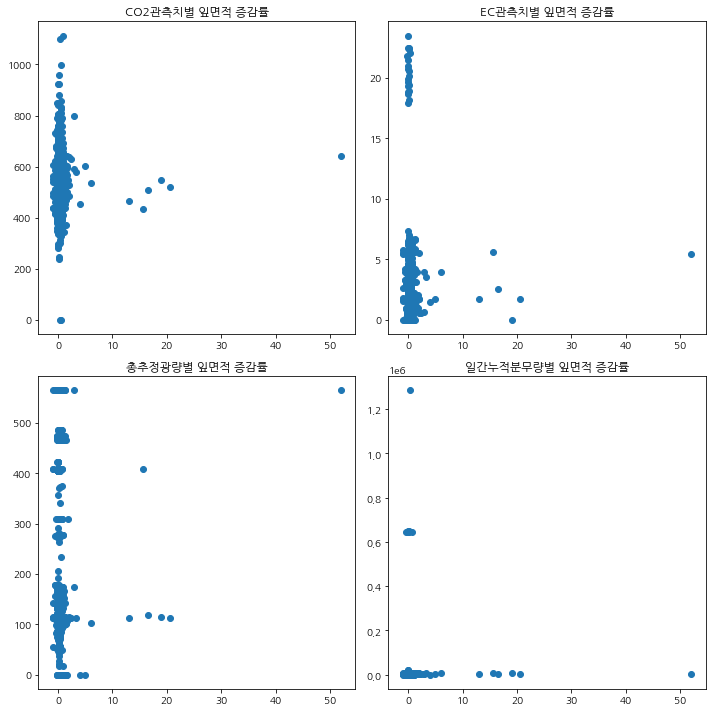

In [29]:
import koreanize_matplotlib 

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs = axs.ravel(order='C')
for i, v in enumerate(['CO2관측치','EC관측치','총추정광량','일간누적분무량']):
    axs[i].scatter(train_df["rate"],train_df[v])
    axs[i].set_title(f"{v}별 잎면적 증감률")
plt.tight_layout()
plt.show()

# sns.scatterplot(train_df['CO2관측치'],train_df['EC관측치'])

<AxesSubplot:xlabel='EC관측치', ylabel='CO2관측치'>

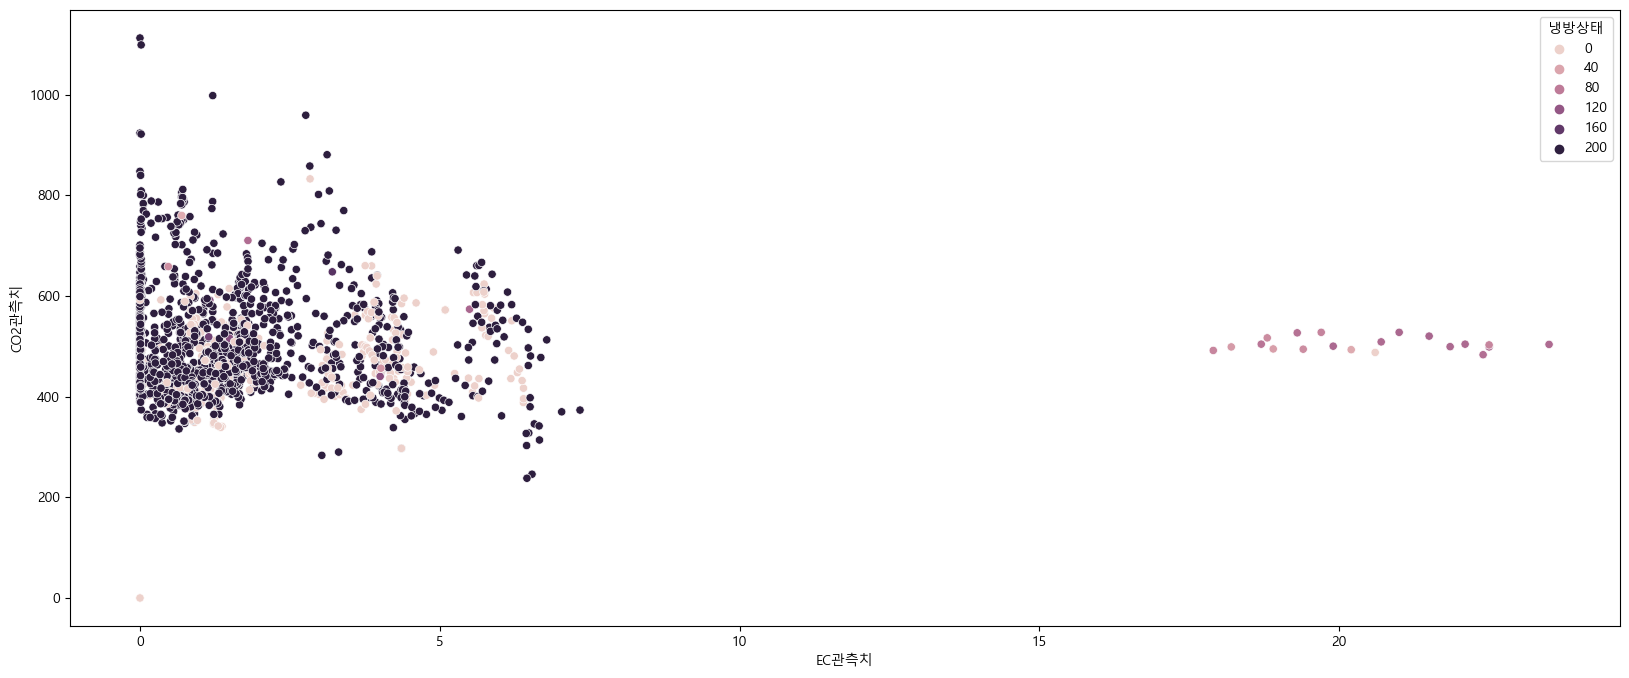

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(train_df['EC관측치'],train_df['CO2관측치'],hue=train_df['냉방상태'])

<AxesSubplot:xlabel='EC관측치', ylabel='CO2관측치'>

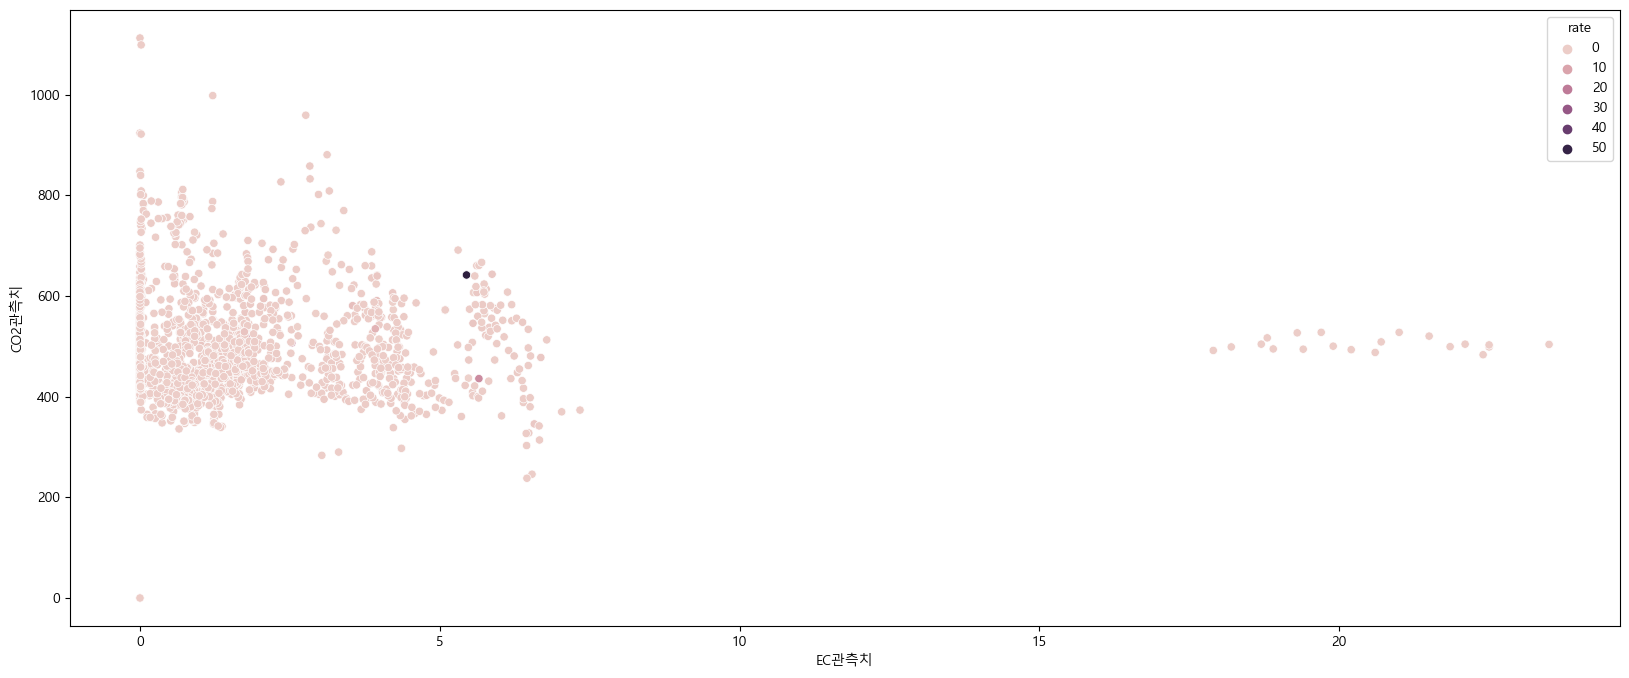

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(train_df['EC관측치'],train_df['CO2관측치'],hue=train_df['rate'])

In [69]:
train_df['rate'].describe()

count    1813.000000
mean        0.319004
std         1.546420
min        -0.946930
25%         0.063080
50%         0.217920
75%         0.333330
max        52.000000
Name: rate, dtype: float64

<AxesSubplot:xlabel='rate', ylabel='총추정광량'>

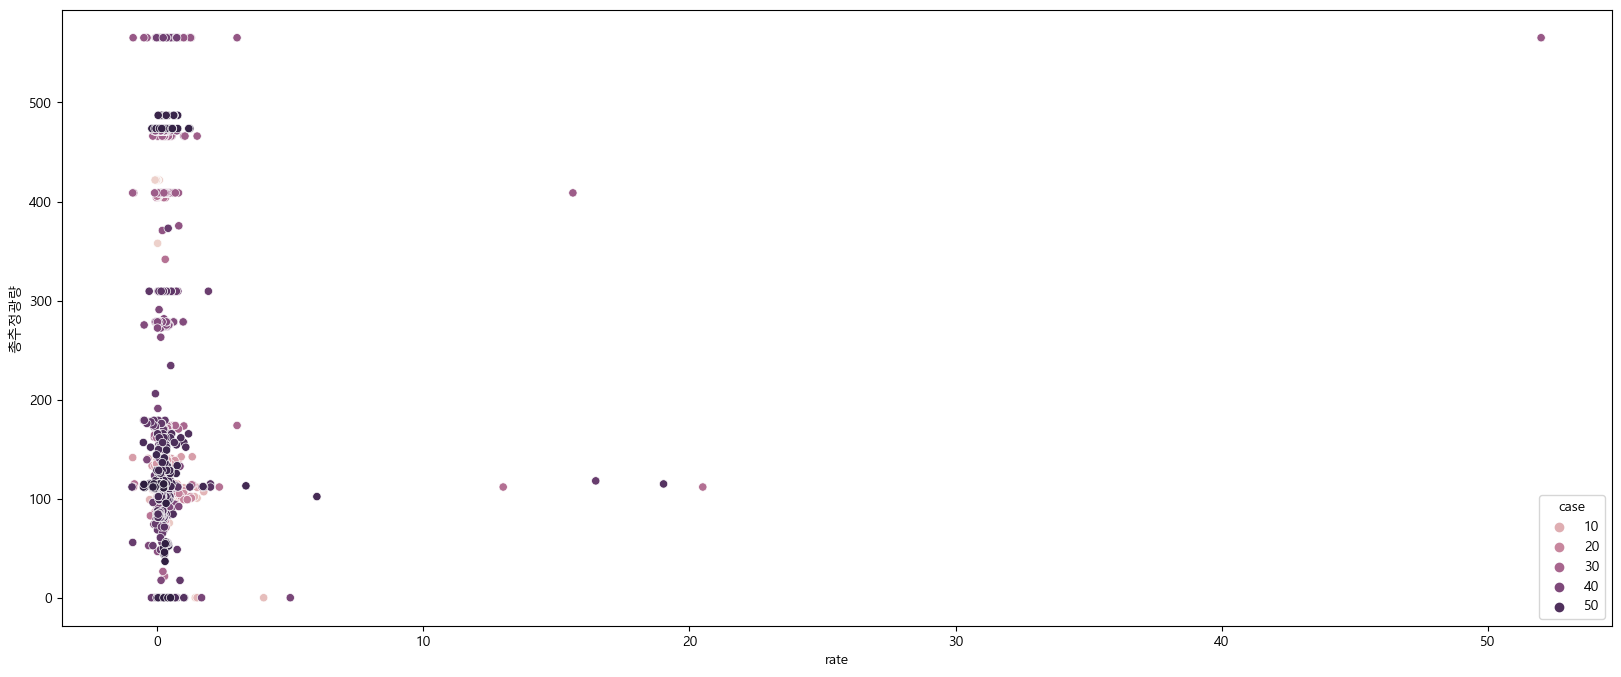

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(train_df['rate'],train_df['총추정광량'], hue=train_df['case'])

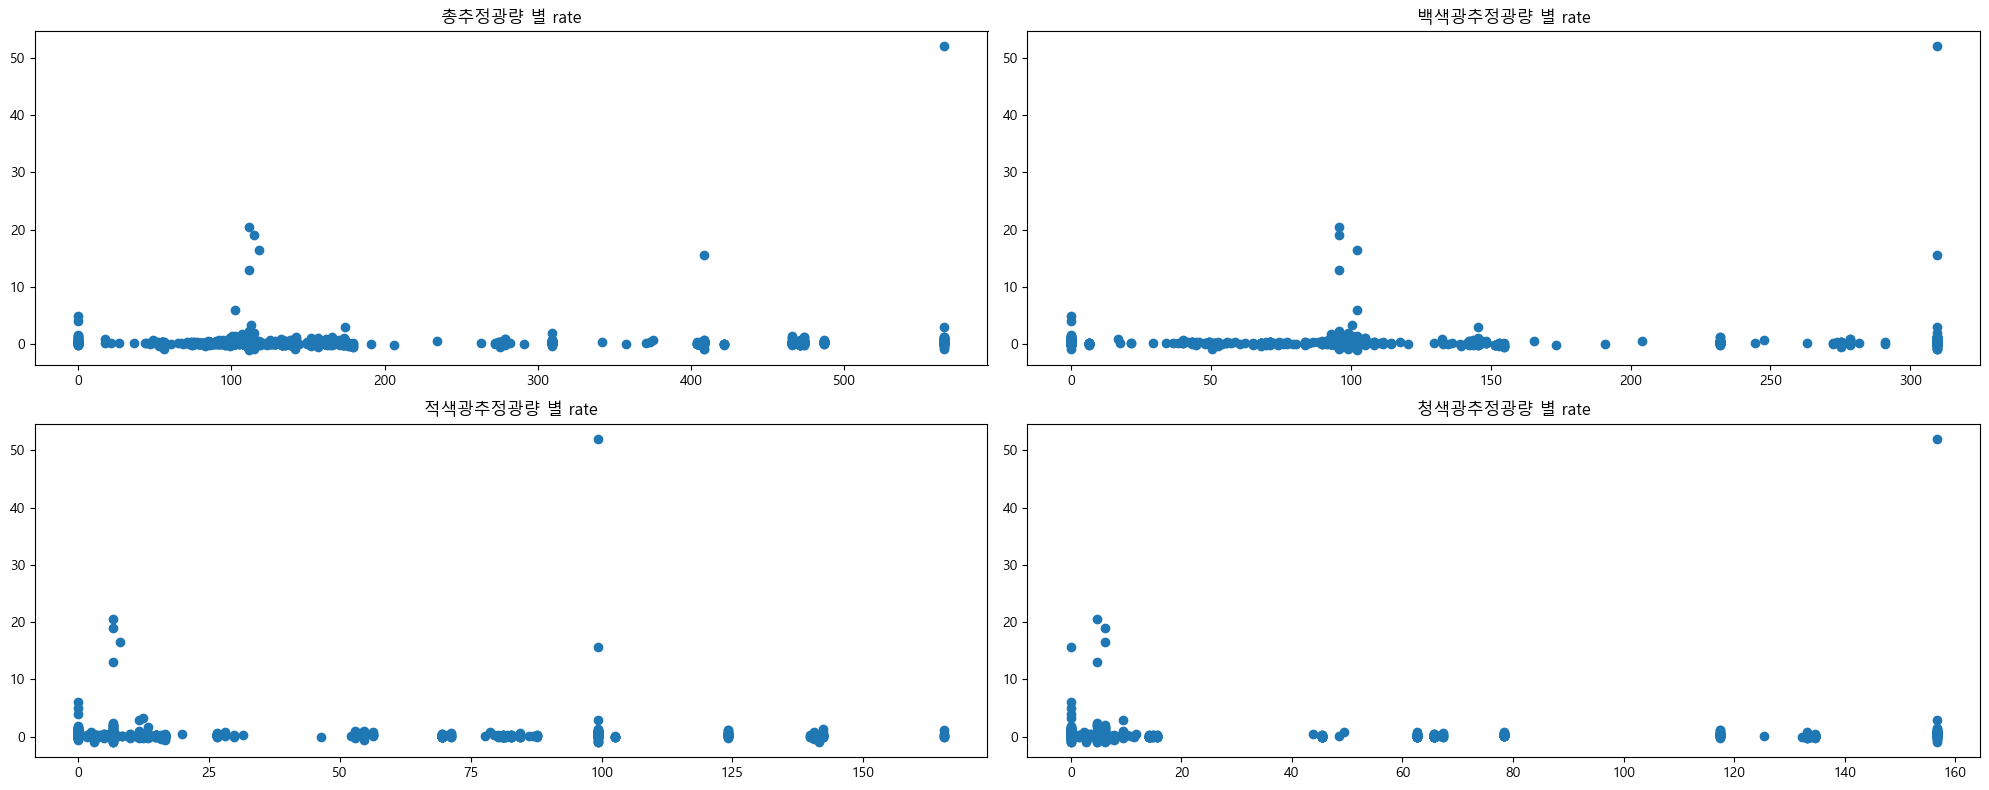

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,8))

axs = axs.ravel(order='C')
for i, v in enumerate(['총추정광량','백색광추정광량','적색광추정광량', '청색광추정광량']):
    axs[i].scatter(train_df[v],train_df['rate'])
    axs[i].set_title(f"{v} 별 rate")
plt.tight_layout()
plt.show()

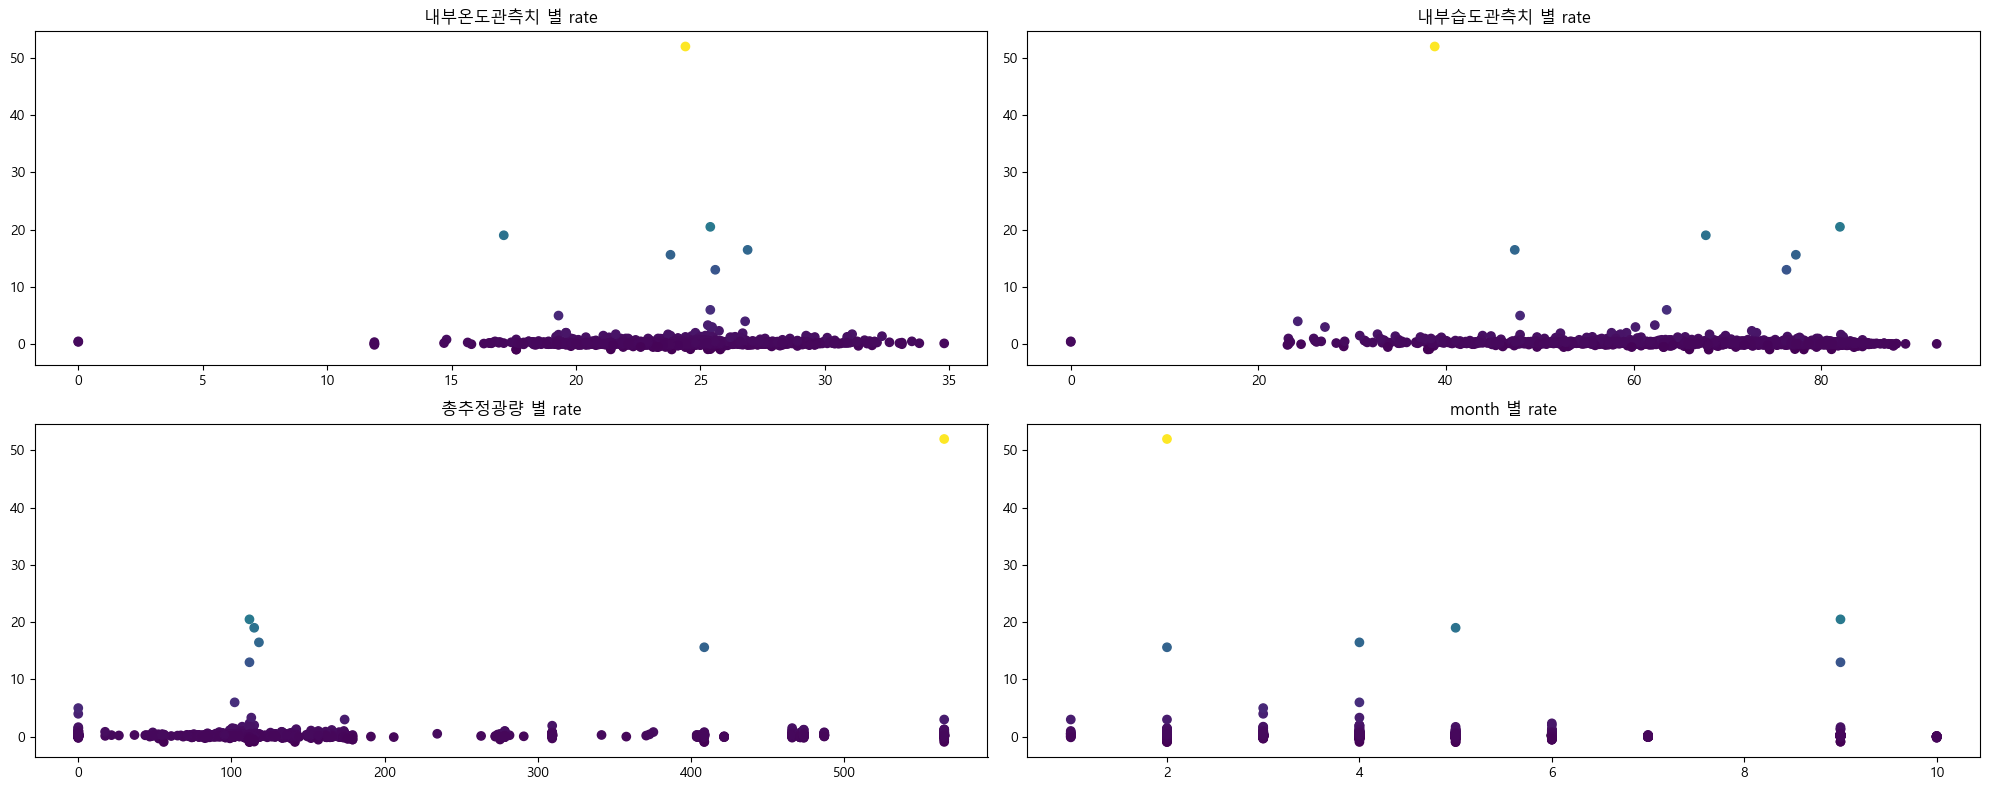

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,8))

axs = axs.ravel(order='C')
for i, v in enumerate(['내부온도관측치','내부습도관측치','총추정광량','month']):
    axs[i].scatter(train_df[v],train_df['rate'],c=train_df['rate'])
    axs[i].set_title(f"{v} 별 rate")
plt.tight_layout()
plt.show()

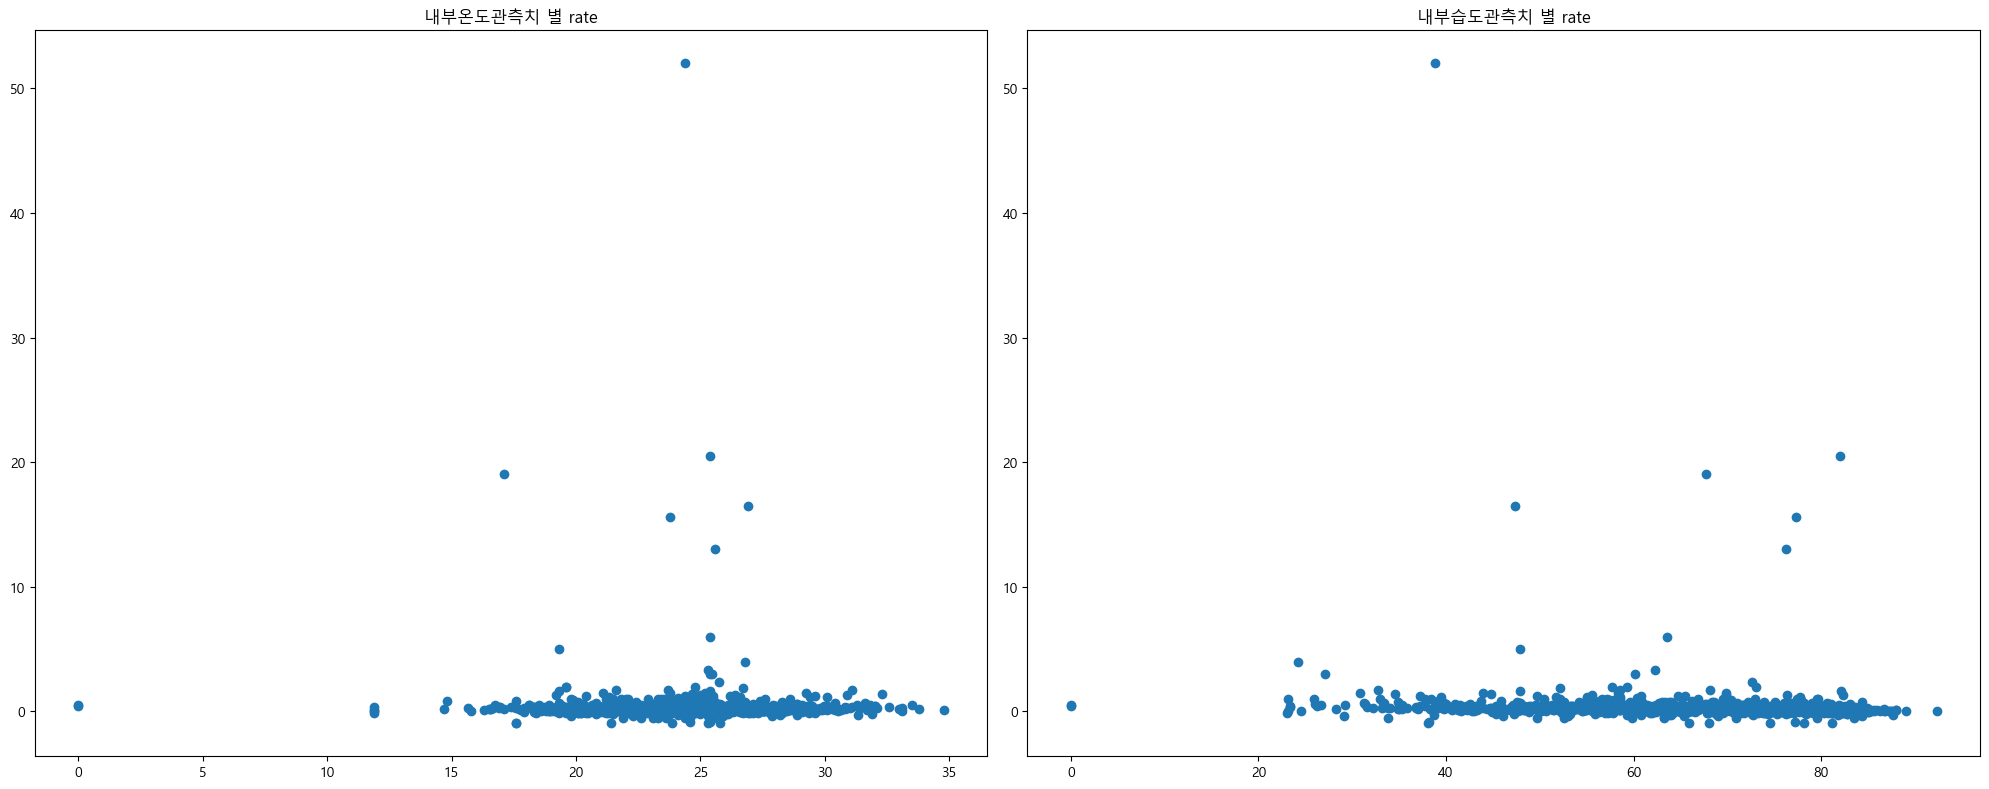

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axs = axs.ravel(order='C')
for i, v in enumerate(['내부온도관측치','내부습도관측치']):
    axs[i].scatter(train_df[v],train_df['rate'])
    axs[i].set_title(f"{v} 별 rate")
plt.tight_layout()
plt.show()

### FE

In [70]:
train_df["spring"] = train_df["month"].apply(lambda x : 1 if x>=3 and x<=5 else 0)
train_df["summer"] = train_df["month"].apply(lambda x : 1 if x>=6 and x<=8 else 0)
train_df["fall"] = train_df["month"].apply(lambda x : 1 if x>=9 and x<=11 else 0)
train_df["winter"] = train_df["month"].apply(lambda x : 1 if x>=12 or x<=2 else 0)

test_df["spring"] = test_df["month"].apply(lambda x : 1 if x>=3 and x<=5 else 0)
test_df["summer"] = test_df["month"].apply(lambda x : 1 if x>=6 and x<=8 else 0)
test_df["fall"] = test_df["month"].apply(lambda x : 1 if x>=9 and x<=11 else 0)
test_df["winter"] = test_df["month"].apply(lambda x : 1 if x>=12 or x<=2 else 0)

train_df.shape, test_df.shape

((1813, 47), (195, 47))

In [71]:
train_df.to_csv('train_final.csv')
test_df.to_csv('test_final.csv')

['year', 'month', 'day', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치',
       '외부온도관측치', '외부습도관측치', '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태',
       '냉방작동남은시간', '난방상태', '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태',
       '외부환기팬작동남은시간', '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태',
       '레드 LED작동남은시간', '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도',
       '카메라상태', '냉방온도', '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량',
       '적색광추정광량', '청색광추정광량', 'time', 'case', 'rate']

In [72]:
ignore_features = ['펌프상태','난방상태','난방작동남은시간','내부유동팬상태','외부온도관측치','외부습도관측치',
                   '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간', 
                   '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도', 
                   '난방온도', '기준온도', '난방부하', '냉방부하',"year", "day"] 

feature = list(set(train_df.columns.tolist()) - set(ignore_features))

train_df = train_df[feature]
test_df = test_df[feature]
train_df.shape, test_df.shape

((1813, 24), (195, 24))

In [73]:
train_X = train_df.drop(columns = 'rate')
train_y = train_df['rate']

test_X = test_df.drop(columns='rate')
test_y = test_df['rate']


train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1813, 23), (195, 23), (1813,), (195,))

In [74]:
# y Transform
IQR = np.quantile(train_y, 0.75) - np.quantile(train_y, 0.25)
min_value = np.quantile(train_y, 0.25) - IQR #* 1.5
max_value = np.quantile(train_y, 0.75) + IQR #* 1.5
train_y = train_y.apply(lambda x : x if x>min_value else min_value)
train_y = train_y.apply(lambda x : x if x<max_value else max_value)

train_y.shape

(1813,)

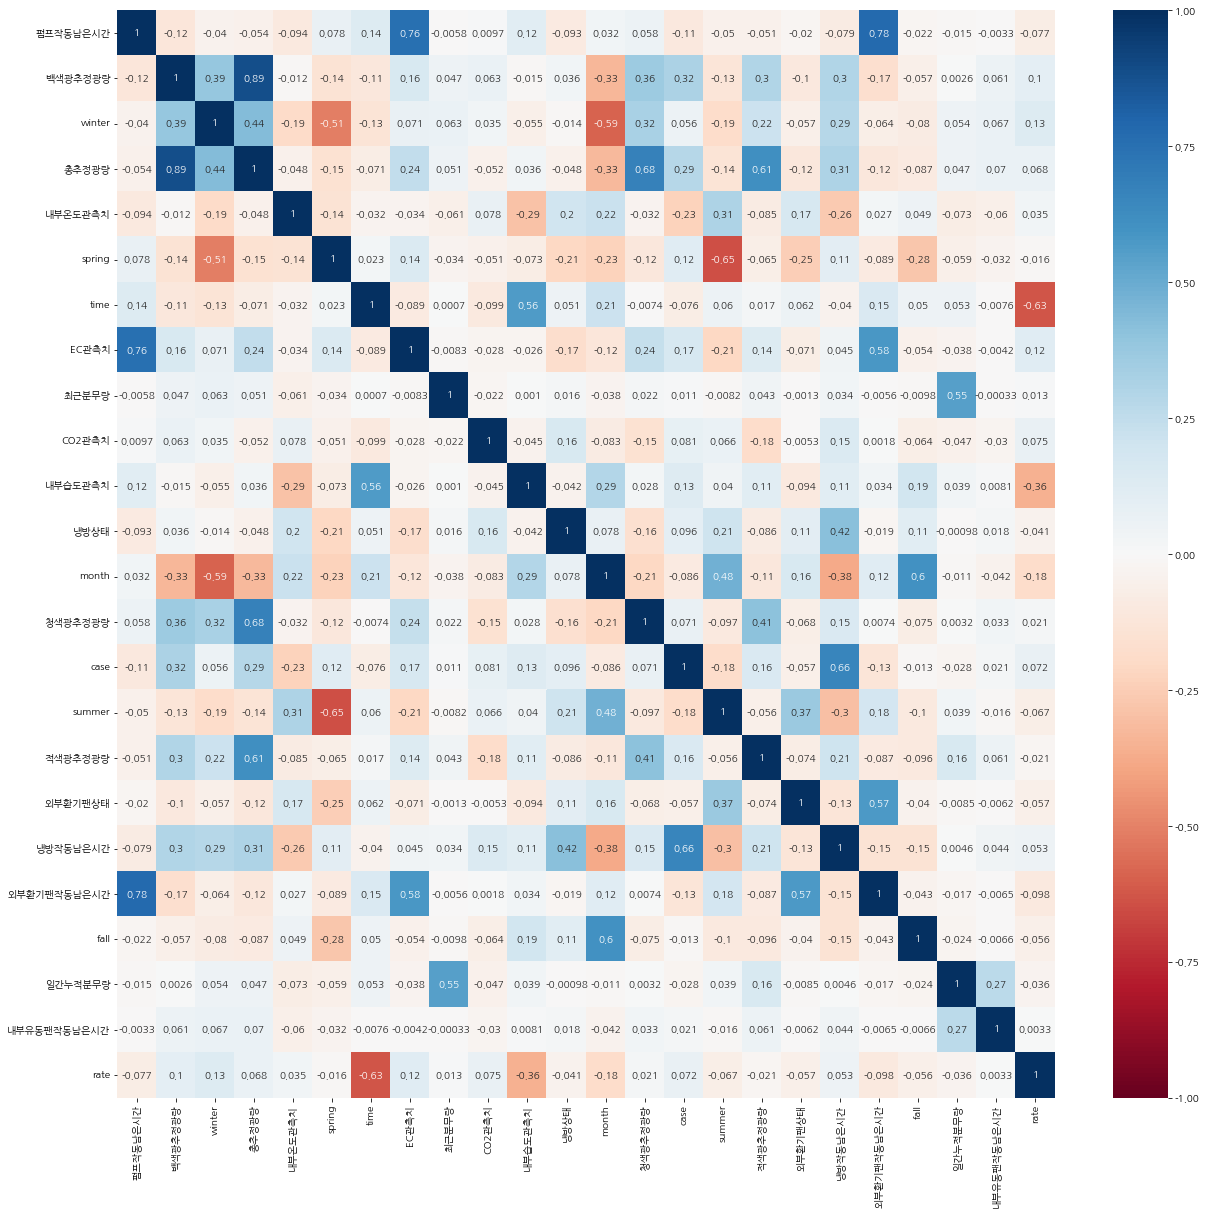

In [35]:
train = pd.concat([train_X, train_y], axis=1)

plt.figure(figsize=(21,20))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

https://dacon.io/competitions/official/235961/codeshare/6591?page=1&dtype=recent

### 내가 시도하는 DNN모델

In [139]:
import tensorflow as tf
import tensorflow.keras as keras

# 난수의 시드값 지정
np.random.seed(1)
tf.random.set_seed(1)

# 기본 하이퍼파라미터 지정.
learning_rate = 0.001 #optimizer에 지정할 학습율.
N_EPOCHS = 1000 #epoch수 - 전체 데이터셋을 몇번 반복해서 학습할 지.
N_BATCH = 32  #batch_size 지정. - 파라미터를 데이터 몇개당 할 것인지. (mini-batch size)

In [86]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1813, 23), (195, 23), (1813,), (195,))

In [90]:
# Dataset으로 변환. (X,y)를 묶어서 제공. 
# drop_reminder매개변수: 남은 짜투리는 버려라.
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))\
                               .shuffle(500)\
                               .batch(N_BATCH, drop_remainder=True)\
                               .repeat() #epoch이 반복되어도 데이터를 계속 공급해야 하기때문에 repeat()을 반드시 한다.
#검증데이터셋.
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(N_BATCH)

In [135]:
# 입력 레이어를 Input 레이어로 사용할 수도 있습니다.  tf.keras.layers.Input(shape=(input_shape))
# 분류와 똑같지만 회귀는 출력을 하나로 합니다.  tf.keras.layers.Dense(1)
# tf.keras.models.Sequential 로 입력-히든-출력(sigmoid) 레이어로 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=128, activation='selu', input_shape=(23,)),
    tf.keras.layers.Dense(units=64, activation='selu'),
    tf.keras.layers.Dense(units=32, activation='selu'),
    tf.keras.layers.Dense(units=16, activation='selu'),
    tf.keras.layers.Dense(units=8, activation='selu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

In [144]:
# 모델을 컴파일 합니다.
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [145]:
# 모델을 요약합니다.
model.compile(optimizer=optimizer, 
              loss=["mae", "mse"], 
              metrics=["mae", "mse"])

In [146]:
#batch 설정시 drop_remainder=True로 했기 때문에 `데이터수/배치사이즈` 에서 몫만 사용. 
#(짜투리 때문에)한 번더 업데이트 안하므로.
steps_per_epoch = train_X.shape[0] // N_BATCH
# test_dataset은 drop_remider=False이므로 나머지가 있을 경우 +1을 해야 한다. (한번 더 실행하도록.)
validation_steps = int(np.ceil(test_X.shape[0]/N_BATCH))

In [147]:
# 학습
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=100)

history = model.fit(train_dataset,    #학습 데이터셋
                    epochs=N_EPOCHS,
                    verbose=0,
                    callbacks=[early_stop],
                    steps_per_epoch=steps_per_epoch,
                    validation_data = test_dataset, #검증 데이터셋
                    validation_steps=validation_steps)

In [149]:
# history 를 데이터프레임으로 만듭니다.
df_hist = pd.DataFrame(history.history)
df_hist.tail(3)

,loss,mae,mse,val_loss,val_mae,val_mse
179,0.051909,0.051909,0.005871,0.212399,0.212399,0.076732
180,0.052739,0.052739,0.006139,0.221491,0.221491,0.085652
181,0.052422,0.052422,0.006131,0.209096,0.209096,0.076769


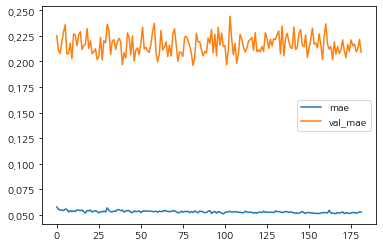

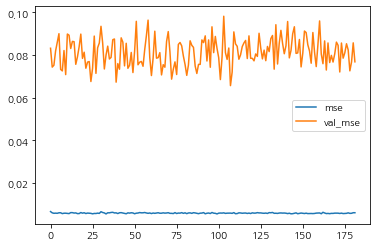

In [150]:
# 학습결과를 시각화 합니다.
df_hist[["mae", "val_mae"]].plot()
df_hist[["mse", "val_mse"]].plot()

### 수업에서 배운 DNN모델 써보기

In [97]:
# input_shape 값을 구합니다. feature의 수로 만듭니다.
# (중요!) X_train.shape[1] 로 input_shape 를 만들어 주세요!
input_shape = train_X.shape[1]
input_shape

23

In [98]:
# 입력 레이어를 Input 레이어로 사용할 수도 있습니다.  tf.keras.layers.Input(shape=(input_shape))
# 분류와 똑같지만 회귀는 출력을 하나로 합니다.  tf.keras.layers.Dense(1)
# tf.keras.models.Sequential 로 입력-히든-출력(sigmoid) 레이어로 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=128, input_shape=[input_shape]),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

In [99]:
# 모델을 컴파일 합니다.
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [100]:
# 모델을 요약합니다.
model.compile(optimizer=optimizer, 
              loss=["mae", "mse"], 
              metrics=["mae", "mse"])

In [101]:
# 모델을 학습합니다.
# 학습결과를 history 변수에 할당합니다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=100)
history = model.fit(train_X, train_y, epochs=1000, verbose=0, 
                    callbacks=[early_stop], validation_split=0.2)

In [104]:
# history 를 데이터프레임으로 만듭니다.
df_hist = pd.DataFrame(history.history)
df_hist.tail(3)

,loss,mae,mse,val_loss,val_mae,val_mse
217,0.102553,0.102553,0.020879,0.134765,0.134765,0.033193
218,0.101441,0.101441,0.020910,0.132526,0.132526,0.032280
219,0.101488,0.101488,0.020856,0.153405,0.153405,0.041224


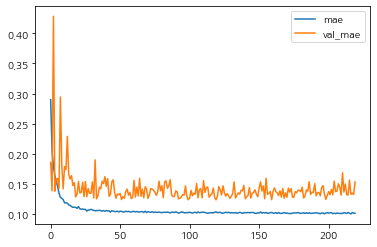

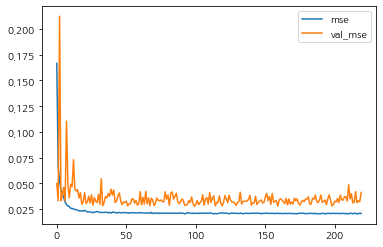

In [105]:
# 학습결과를 시각화 합니다.
df_hist[["mae", "val_mae"]].plot()
df_hist[["mse", "val_mse"]].plot()

### 예측 및 제출

In [106]:
y_pred = model.predict(test_X)
y_pred.shape

7/7 [==============================] - 0s 3ms/step


(195, 1)

In [107]:
# 예측값을 flatten을 사용해 1차원으로 변환합니다. 
y_predict = y_pred.flatten()
y_predict[:5] 

array([0.42504355, 0.4035007 , 0.39720753, 0.38566497, 0.36407447],
      dtype=float32)

In [126]:
base_path = f'/content/drive/My Drive/Colab Notebooks/BokChoy/'

In [127]:
submit_path = f'{base_path}/sample_submission'

submit_df1 = pd.read_csv(f"{submit_path}/TEST_01.csv")
submit_df1.head()

,시간,rate
0,2021-03-27 00:00:00,0
1,2021-03-28 00:00:00,0
2,2021-03-29 00:00:00,0
3,2021-03-30 00:00:00,0
4,2021-03-31 00:00:00,0


In [128]:
# ((29, 2), (35, 2), (26, 2), (32, 2), (37, 2), (36, 2))
submit_df1 = pd.read_csv(f"{submit_path}/TEST_01.csv")
submit_df1["rate"] = y_pred[:29]
submit_df1.to_csv(f"{submit_path}/TEST_01.csv", index=False)

submit_df2 = pd.read_csv(f"{submit_path}/TEST_02.csv")
submit_df2["rate"] = y_pred[29:29+35]
submit_df2.to_csv(f"{submit_path}/TEST_02.csv", index=False)

submit_df3 = pd.read_csv(f"{submit_path}/TEST_03.csv")
submit_df3["rate"] = y_pred[29+35:29+35+26]
submit_df3.to_csv(f"{submit_path}/TEST_03.csv", index=False)

submit_df4 = pd.read_csv(f"{submit_path}/TEST_04.csv")
submit_df4["rate"] = y_pred[29+35+26:29+35+26+32]
submit_df4.to_csv(f"{submit_path}/TEST_04.csv", index=False)

submit_df5 = pd.read_csv(f"{submit_path}/TEST_05.csv")
submit_df5["rate"] = y_pred[29+35+26+32:29+35+26+32+37]
submit_df5.to_csv(f"{submit_path}/TEST_05.csv", index=False)

submit_df6 = pd.read_csv(f"{submit_path}/TEST_06.csv")
submit_df6["rate"] = y_pred[29+35+26+32+37:]
submit_df6.to_csv(f"{submit_path}/TEST_06.csv", index=False)


submit_df1.shape, submit_df2.shape, submit_df3.shape, submit_df4.shape, submit_df5.shape, submit_df6.shape

((29, 2), (35, 2), (26, 2), (32, 2), (37, 2), (36, 2))

In [ ]:
submit_df1

In [130]:
test_target_list = [f'{i[1:]}'.replace('\\','/') for i in test_target_list]

In [132]:
import zipfile
base_path = f'/content/drive/My Drive/Colab Notebooks/BokChoy/'
os.chdir(f'{base_path}/sample_submission/')
submission = zipfile.ZipFile(f"{submit_path}/sample_submission_1.zip", 'w')
for path in test_target_list:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()